# UmojaHack Africa 2022: Faulty Air Quality Sensor Challenge V2.0
# By Mohamed Eltayeb

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [2]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

# Read the training and testing data


In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Convert the Tabular Data to Time Series Data

In [4]:
train_df = train_df.sort_values('Datetime').reset_index(drop=True) 
test_df = test_df.sort_values('Datetime').reset_index(drop=True)

for dataset in (train_df,test_df):
    dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])
    dataset['Day'] = dataset.Datetime.dt.day
    dataset['Month'] = dataset.Datetime.dt.month
    dataset['Year'] = dataset.Datetime.dt.year
    dataset['Hour'] = dataset.Datetime.dt.hour
    dataset['Minute'] = dataset.Datetime.dt.minute
    dataset['Seconds'] = dataset.Datetime.dt.second
    dataset['DayOfWeek'] = dataset.Datetime.dt.dayofweek
    dataset['DayOfYear'] = dataset.Datetime.dt.dayofyear
    dataset['Week'] = dataset.Datetime.dt.weekofyear
    dataset.set_index('Datetime', inplace=True)

In [5]:
ID = test_df['ID']
test_df.drop('ID',inplace=True,axis=1)
train_df.drop('ID',inplace=True,axis=1)

# Exploratory data analysis

# Features:

* $Offset fault$: Is the device faulty or not? [Target]
* $ID$: Unique Id of each sample
* $Sensor1 PM2.5$: Values of the first sensor
* $Sensor2 PM2.5$: Values of the second sensor
* $Temperature$: Temperature
* $Relative Humidity$: Relative Humidity

In [6]:
train_df.shape

(297177, 14)

In [7]:
test_df.shape

(127361, 13)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 297177 entries, 2021-10-15 16:00:31 to 2022-01-21 07:34:57
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Sensor1_PM2.5      293563 non-null  float64
 1   Sensor2_PM2.5      293563 non-null  float64
 2   Temperature        293628 non-null  float64
 3   Relative_Humidity  293628 non-null  float64
 4   Offset_fault       297177 non-null  int64  
 5   Day                297177 non-null  int64  
 6   Month              297177 non-null  int64  
 7   Year               297177 non-null  int64  
 8   Hour               297177 non-null  int64  
 9   Minute             297177 non-null  int64  
 10  Seconds            297177 non-null  int64  
 11  DayOfWeek          297177 non-null  int64  
 12  DayOfYear          297177 non-null  int64  
 13  Week               297177 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 34.0 MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127361 entries, 2022-01-21 07:35:50 to 2022-03-14 14:50:35
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Sensor1_PM2.5      127361 non-null  float64
 1   Sensor2_PM2.5      127361 non-null  float64
 2   Temperature        39271 non-null   float64
 3   Relative_Humidity  39271 non-null   float64
 4   Day                127361 non-null  int64  
 5   Month              127361 non-null  int64  
 6   Year               127361 non-null  int64  
 7   Hour               127361 non-null  int64  
 8   Minute             127361 non-null  int64  
 9   Seconds            127361 non-null  int64  
 10  DayOfWeek          127361 non-null  int64  
 11  DayOfYear          127361 non-null  int64  
 12  Week               127361 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 13.6 MB


In [10]:
train_df.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Day,Month,Year,Hour,Minute,Seconds,DayOfWeek,DayOfYear,Week
Datetime,,,,,,,,,,,,,,
2021-10-15 16:00:31,9.17,9.28,29.9,53.0,0,15,10,2021,16,0,31,4,288,41
2021-10-15 16:00:34,9.93,11.25,29.9,53.0,0,15,10,2021,16,0,34,4,288,41
2021-10-15 16:01:01,6.53,3.15,29.9,53.0,1,15,10,2021,16,1,1,4,288,41
2021-10-15 16:01:54,8.30,8.35,29.9,53.0,0,15,10,2021,16,1,54,4,288,41
2021-10-15 16:02:06,6.87,9.57,29.9,53.0,0,15,10,2021,16,2,6,4,288,41


In [11]:
test_df.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Day,Month,Year,Hour,Minute,Seconds,DayOfWeek,DayOfYear,Week
Datetime,,,,,,,,,,,,,
2022-01-21 07:35:50,43.92,50.28,16.9,79.0,21,1,2022,7,35,50,4,21,3
2022-01-21 07:36:01,49.52,46.80,16.9,79.0,21,1,2022,7,36,1,4,21,3
2022-01-21 07:36:07,41.47,32.08,16.9,79.0,21,1,2022,7,36,7,4,21,3
2022-01-21 07:37:21,38.07,32.60,16.9,79.0,21,1,2022,7,37,21,4,21,3
2022-01-21 07:37:21,49.02,44.20,16.9,79.0,21,1,2022,7,37,21,4,21,3


In [12]:
train_df.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Day,Month,Year,Hour,Minute,Seconds,DayOfWeek,DayOfYear,Week
count,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000
mean,40.751195,38.183018,23.316554,78.653623,0.371072,15.993536,9.069800,2021.207876,11.394671,29.488823,29.495678,2.989390,261.088748,38.453851
std,28.526182,28.647761,3.836971,14.772725,0.483092,8.665787,4.188691,0.405788,6.943538,17.312323,17.323682,2.000969,129.827032,17.748359
min,-9.450000,-9.700000,16.700000,27.000000,0.000000,1.000000,1.000000,2021.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000,9.000000,10.000000,2021.000000,5.000000,14.000000,14.000000,1.000000,292.000000,42.000000
50%,36.470000,33.720000,21.900000,84.000000,0.000000,16.000000,11.000000,2021.000000,11.000000,29.000000,29.000000,3.000000,317.000000,46.000000
75%,49.420000,47.570000,26.300000,91.000000,1.000000,23.000000,12.000000,2021.000000,17.000000,44.000000,44.000000,5.000000,341.000000,49.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000,31.000000,12.000000,2022.000000,23.000000,59.000000,59.000000,6.000000,365.000000,52.000000


In [13]:
test_df.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Day,Month,Year,Hour,Minute,Seconds,DayOfWeek,DayOfYear,Week
count,127361.000000,127361.000000,39271.000000,39271.000000,127361.000000,127361.000000,127361.0,127361.000000,127361.000000,127361.000000,127361.000000,127361.000000,127361.000000
mean,42.795356,43.958427,23.683838,72.215834,14.879720,2.117854,2022.0,11.469186,29.526613,29.476237,3.081823,48.622318,7.077214
std,27.838730,28.260335,3.725563,18.078569,9.483789,0.689573,0.0,6.904409,17.314057,17.310633,1.942945,14.928292,2.123567
min,1.230000,0.780000,16.900000,28.000000,1.000000,1.000000,2022.0,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
25%,24.670000,25.580000,20.900000,58.000000,6.000000,2.000000,2022.0,5.000000,15.000000,14.000000,1.000000,34.000000,5.000000
50%,39.770000,39.880000,22.500000,78.000000,13.000000,2.000000,2022.0,12.000000,30.000000,29.000000,3.000000,50.000000,7.000000
75%,52.030000,52.830000,26.500000,88.000000,24.000000,3.000000,2022.0,17.000000,45.000000,44.000000,5.000000,62.000000,9.000000
max,927.780000,894.750000,34.000000,97.000000,31.000000,3.000000,2022.0,23.000000,59.000000,59.000000,6.000000,73.000000,11.000000


# Plots


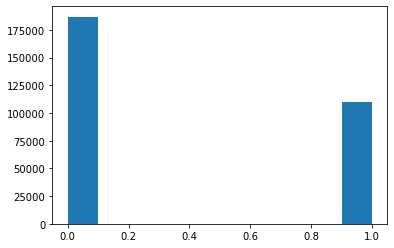

In [14]:
#Target Histogram
plt.hist(train_df['Offset_fault']);

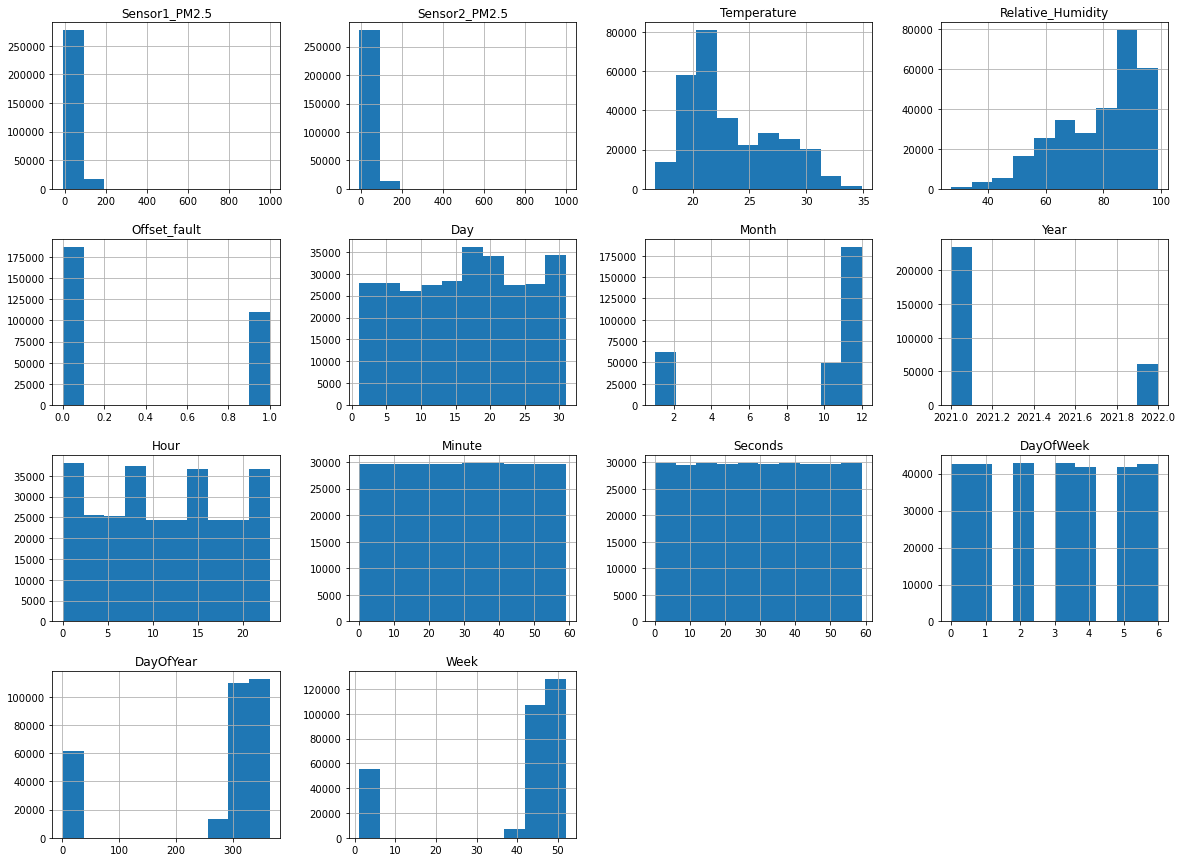

In [15]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

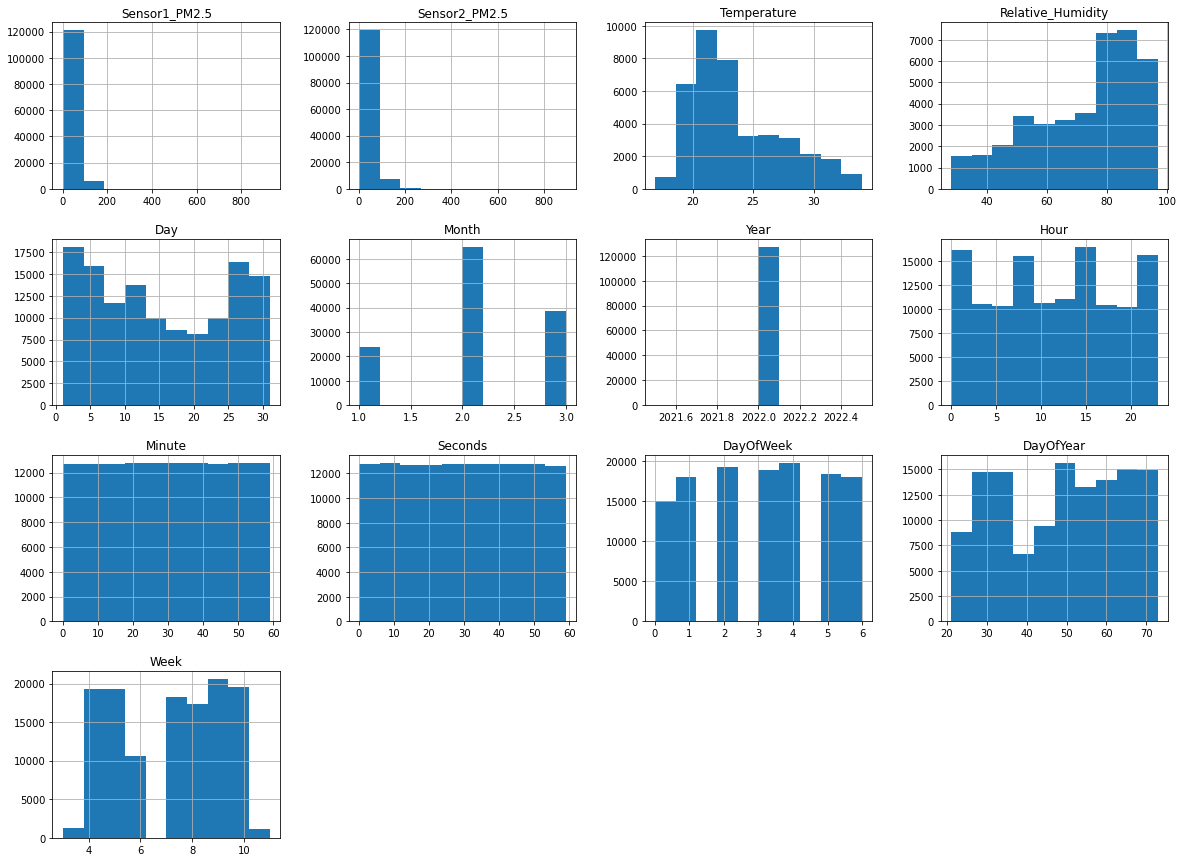

In [16]:
#Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15));

#### The Histograms are almost the same in the training and testing data. 

### Sensor1_PM2.5

[]

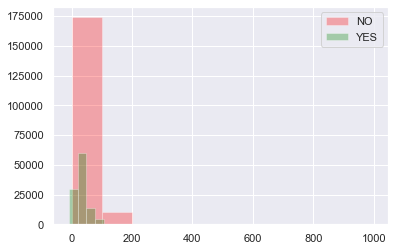

In [17]:
sns.set()
plt.hist(train_df[train_df['Offset_fault'] == 0]['Sensor1_PM2.5'], color='red', alpha = 0.3, label = 'NO')
plt.hist(train_df[train_df['Offset_fault'] == 1]['Sensor1_PM2.5'], color='green', alpha=0.3, label = 'YES')
plt.legend()
plt.plot()

### Sensor2_PM2.5

[]

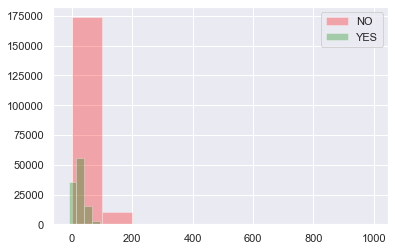

In [18]:
sns.set()
plt.hist(train_df[train_df['Offset_fault'] == 0]['Sensor2_PM2.5'], color='red', alpha = 0.3, label = 'NO')
plt.hist(train_df[train_df['Offset_fault'] == 1]['Sensor2_PM2.5'], color='green', alpha=0.3, label = 'YES')
plt.legend()
plt.plot()

### Sensor1_PM2.5 VS Sensor2_PM2.5

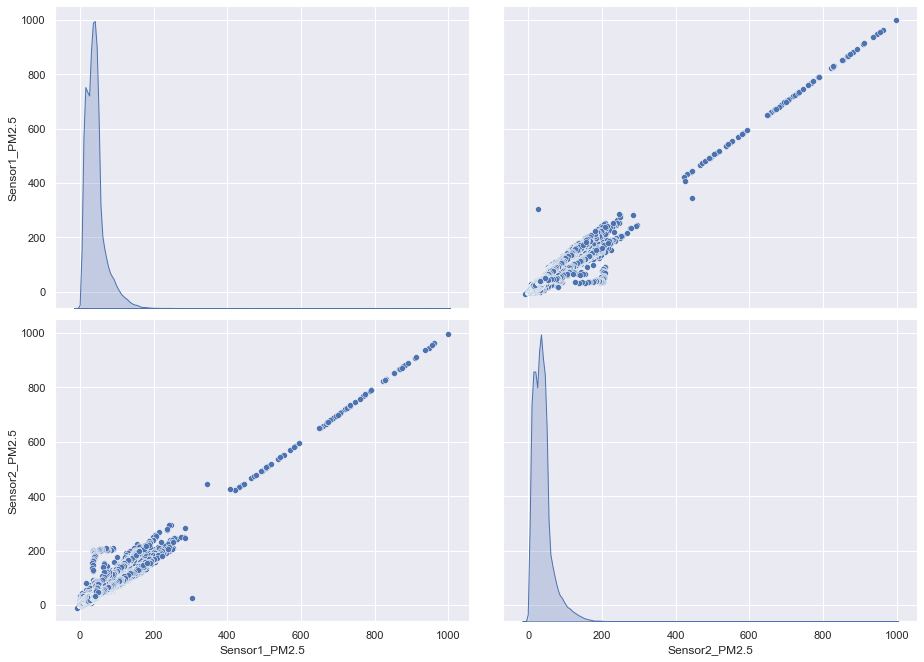

In [19]:
attributes = ["Sensor1_PM2.5", "Sensor2_PM2.5"]
sns.pairplot(train_df[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

#### It is very likely that these two features measure the same thing as that they have a very strong linear correlation. 

### Year

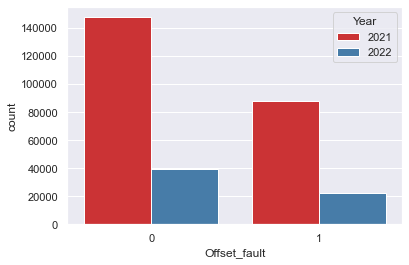

In [20]:
sns.countplot( x='Offset_fault', data=train_df, hue="Year", palette="Set1");

#### Most of the samples are from 2021. Let's check the months:

### Month

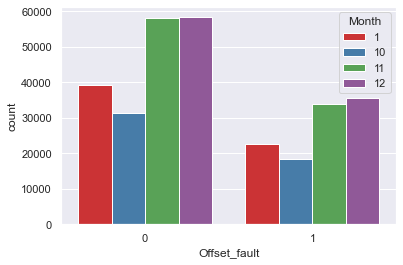

In [21]:
sns.countplot( x='Offset_fault', data=train_df, hue="Month", palette="Set1");

#### The data were taken during the last three months of 2021 and the first month of 2022 which explains the low amount of samples in 2022.

## Day

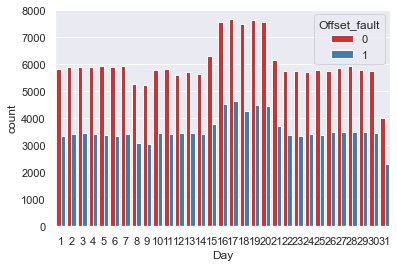

In [22]:
sns.countplot( x='Day', data=train_df, hue="Offset_fault", palette="Set1");

###### It looks like many samples were taken between 15 and 20 of each month.


## Hour

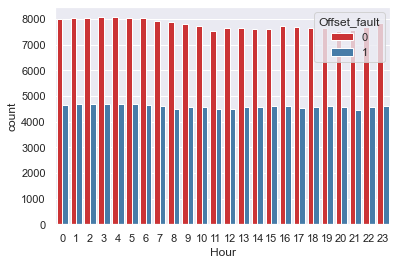

In [23]:
sns.countplot( x='Hour', data=train_df, hue="Offset_fault", palette="Set1");

## Temperature --- Datetime_month

[]

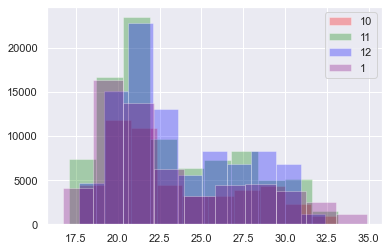

In [24]:
sns.set()
plt.hist(train_df[train_df['Month'] == 10].Temperature, color='red', alpha = 0.3, label = 10)
plt.hist(train_df[train_df['Month'] == 11].Temperature, color='green', alpha=0.3, label = 11)
plt.hist(train_df[train_df['Month'] == 12].Temperature, color='blue', alpha=0.3, label = 12)
plt.hist(train_df[train_df['Month'] == 1].Temperature, color='purple', alpha=0.3, label = 1)
plt.legend()
plt.plot()

#### The temperature for all months is almost identical with a small increase in January.

# Feature Engineering

## Combination Between Time Features
 

In [25]:
for dataset in (train_df,test_df):
    dataset['Year_Week'] = dataset['Year'].astype(str) + '-' + dataset['Week'].astype(str)
    dataset['Month_Day'] = dataset['Month'].astype(str) + '-' + dataset['Day'].astype(str)
    dataset['Month_Day_Hour']  = dataset['Month'].astype(str) + '-' + dataset['Day'].astype(str) + '-' + dataset['Hour'].astype(str)
    dataset['Month_Day_Hour_Minute']  = dataset['Month'].astype(str) + '-' + dataset['Day'].astype(str) + '-' + dataset['Hour'].astype(str) + '-' + dataset['Minute'].astype(str)

## Lags Features

In [26]:
for dataset in (train_df,test_df):
    dataset['Sensor1_LagN3'] = dataset['Sensor1_PM2.5'].shift(-3)

## Rolling for The Sensors Features

In [27]:
def rolling(feature):
    for dataset in (train_df,test_df):
        dataset['Rolling_3'] = dataset[feature].rolling(3).mean()
        dataset['Rolling_5'] = dataset[feature].rolling(5).mean()

        dataset[f"{feature}_rolling_mean_60"] = dataset.rolling(60).mean()[feature]
        dataset[f"{feature}_rolling_max_60"] = dataset.rolling(60).max()[feature]
        dataset[f"{feature}_rolling_min_60"] = dataset.rolling(60).min()[feature]

        dataset[f"{feature}_rolling_mean_30"] = dataset.rolling(30).mean()[feature]
        dataset[f"{feature}_rolling_max_30"] = dataset.rolling(30).max()[feature]
        dataset[f"{feature}_rolling_min_30"] = dataset.rolling(30).min()[feature]

        dataset[f"{feature}_rolling_mean_10"] = dataset.rolling(10).mean()[feature]
        dataset[f"{feature}_rolling_max_10"] = dataset.rolling(10).max()[feature]
        dataset[f"{feature}_rolling_min_10"] = dataset.rolling(10).min()[feature]

rolling('Sensor1_PM2.5')
rolling('Sensor2_PM2.5')

## Statistics of The Two Sensors 

In [28]:
def MeanSd(feature1, feature2):
    for dataset in (train_df,test_df):
        dataset["SD"] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN"] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('Sensor1_PM2.5','Sensor2_PM2.5')

## Add Aggregations

In [29]:
def label_enc(train_df, test_df, features):
    lbl_enc = LabelEncoder()
    full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis=0)
    for col in (features):
        print(col)
        if train_df[col].dtype == 'object':
            lbl_enc.fit(full_data[col].values)
            train_df[col] = lbl_enc.transform(train_df[col])
            test_df[col] = lbl_enc.transform(test_df[col])            
    return train_df, test_df

feats = ['Month_Day_Hour_Minute','Month_Day_Hour','Month_Day','Year_Week']
train_df,test_df = label_enc(train_df,test_df,feats)

Month_Day_Hour_Minute
Month_Day_Hour
Month_Day
Year_Week


In [30]:
def Agg(Feature):
    for dataset in (train_df,test_df):
        dataset[f'{Feature}PerMonth'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].mean()))
        dataset[f'{Feature}PerWeek'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].mean()))
        dataset[f'{Feature}PerDay'] = dataset['Month_Day'].map(dict(dataset.groupby('Month_Day')[Feature].mean()))
        dataset[f'{Feature}PerHour'] = dataset['Month_Day_Hour'].map(dict(dataset.groupby('Month_Day_Hour')[Feature].mean()))
        dataset[f'{Feature}PerMinute'] = dataset['Month_Day_Hour_Minute'].map(dict(dataset.groupby('Month_Day_Hour_Minute')[Feature].mean()))

        dataset[f'{Feature}Month_std'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].std()))
        dataset[f'{Feature}Week_std'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].std()))
        dataset[f'{Feature}Day_std'] = dataset['Month_Day'].map(dict(dataset.groupby('Month_Day')[Feature].std()))
        dataset[f'{Feature}Hour_std'] = dataset['Month_Day_Hour'].map(dict(dataset.groupby('Month_Day_Hour')[Feature].std()))
        dataset[f'{Feature}Minute_std'] = dataset['Month_Day_Hour_Minute'].map(dict(dataset.groupby('Month_Day_Hour_Minute')[Feature].std()))

        dataset[f'{Feature}Month_min'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].min()))
        dataset[f'{Feature}Week_min'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].min()))
        dataset[f'{Feature}Day_min'] = dataset['Month_Day'].map(dict(dataset.groupby('Month_Day')[Feature].min()))
        dataset[f'{Feature}Hour_min'] = dataset['Month_Day_Hour'].map(dict(dataset.groupby('Month_Day_Hour')[Feature].min()))
        dataset[f'{Feature}Minute_min'] = dataset['Month_Day_Hour_Minute'].map(dict(dataset.groupby('Month_Day_Hour_Minute')[Feature].min()))

        dataset[f'{Feature}Month_max'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].max()))
        dataset[f'{Feature}Week_max'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].max()))
        dataset[f'{Feature}Day_max'] = dataset['Month_Day'].map(dict(dataset.groupby('Month_Day')[Feature].max()))
        dataset[f'{Feature}Hour_max'] = dataset['Month_Day_Hour'].map(dict(dataset.groupby('Month_Day_Hour')[Feature].max()))
        dataset[f'{Feature}Minute_max'] = dataset['Month_Day_Hour_Minute'].map(dict(dataset.groupby('Month_Day_Hour_Minute')[Feature].max()))

Agg('Sensor2_PM2.5')
Agg('Sensor1_PM2.5')
Agg('Temperature')
Agg('Relative_Humidity')                                                                        
train_df.drop(['Relative_HumidityMinute_std','Relative_HumidityHour_std','TemperatureMinute_std','TemperatureHour_std'],inplace=True,axis=1)                                                      
test_df.drop(['Relative_HumidityMinute_std','Relative_HumidityHour_std','TemperatureMinute_std','TemperatureHour_std'],inplace=True,axis=1)                                                      

# Modeling

In [31]:
lgbm = LGBMClassifier(max_depth=7, random_state=42)

## Validation 

In [32]:
X = train_df.drop('Offset_fault',axis=1).values
y = train_df['Offset_fault'].values
tscv = TimeSeriesSplit(n_splits=2)
scores = []
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_Train, X_Test = X[train_index], X[test_index]
    y_Train, y_Test = y[train_index], y[test_index]
    lgbm.fit(X_Train,y_Train)
    y_pred = lgbm.predict(X_Test)
    scores.append(accuracy_score(y_pred,y_Test))
print("Scores:", scores)

TRAIN: [    0     1     2 ... 99056 99057 99058] TEST: [ 99059  99060  99061 ... 198115 198116 198117]
TRAIN: [     0      1      2 ... 198115 198116 198117] TEST: [198118 198119 198120 ... 297174 297175 297176]
Scores: [0.9879970522617834, 0.9349175743748676]


## Show the Features Importances 

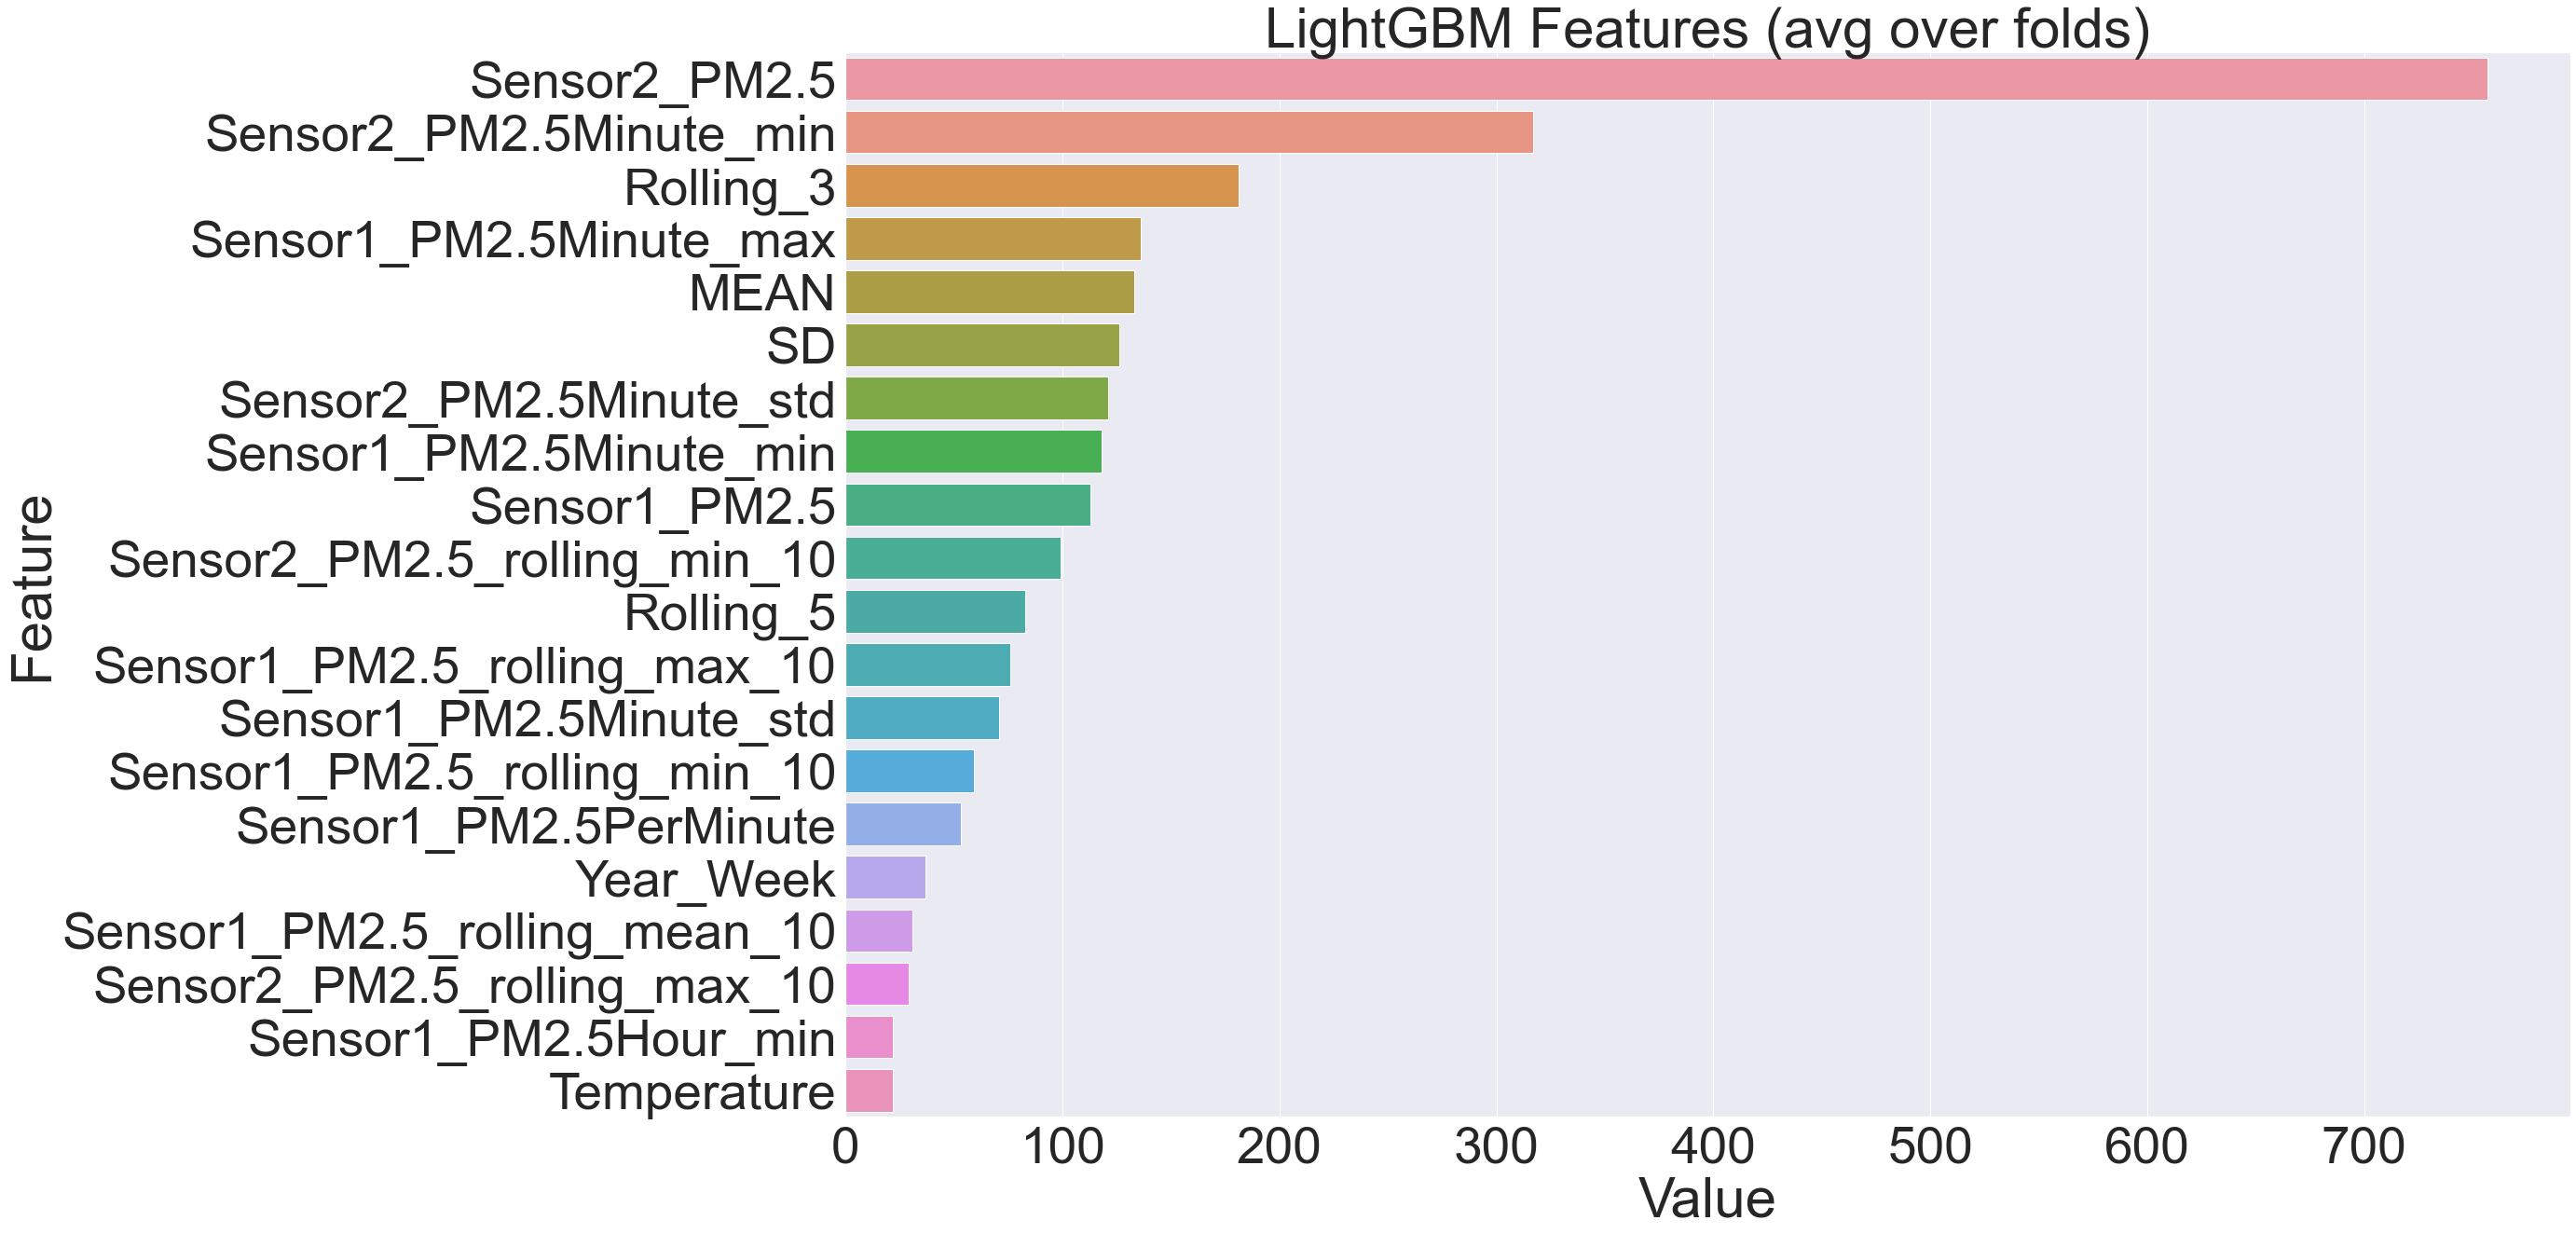

In [33]:
lgbm.fit(train_df.drop('Offset_fault',axis=1),train_df['Offset_fault'])
plotImp(lgbm,train_df.drop('Offset_fault',axis=1))

## The Final Model 

In [34]:
X = train_df.drop('Offset_fault',axis=1)
y = train_df['Offset_fault']

In [65]:
lgbm.fit(X,y)
FinalPred = lgbm.predict(test_df)

## Make the Submission File 

In [66]:
submission = pd.DataFrame({"Id": ID ,"Offset_Fault": FinalPred})
submission.to_csv('FinalSubmission.csv',index=False)

## Final Accuracy: 94.74%